In [33]:
import timm
from PIL import Image
import torch
from torchvision import transforms
from torch.nn import functional as F
import timm.models.mlp_mixer
import numpy as np
import exchange_tensor_array as exchange
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.datasets.utils import download_url
import json

import copy
#モデル作成
model = timm.create_model("gmlp_s16_224", pretrained=True)
model.eval()
print("model")

transform = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
        transforms.ToTensor(),  # テンソルにする。
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # 標準化する。
    ]
)

transform_beta = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
    ]
)

img = Image.open("cat.jpg")
inputs = transform(img)
inputs = inputs.unsqueeze(0)
#plt.imshow(inputs[0].permute(1,2,0))
copy_inputs = copy.deepcopy(inputs)

model


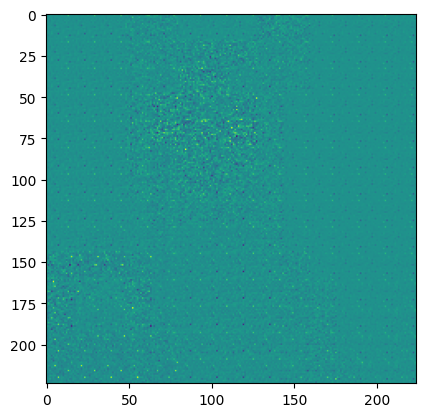

In [2]:
output0 = model(inputs)
mid0 = model.blocks[0].block_output
mid0 = exchange.exchange_tensor_to_array(mid0)
plt.imshow(mid0)

225


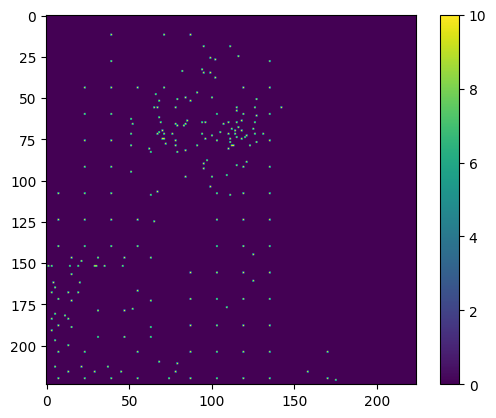

In [3]:
from sklearn.cluster import DBSCAN
y, x = np.where((abs(mid0) > 3))
l = len(y)
p = [ [y[i], x[i]] for i in range(l)]
print(l)
tmp = np.zeros((224, 224))
for u, v in p:
    tmp[u, v] = 10
exchange.show_heatmap_with_colorbar(tmp)


In [ ]:
for i in range(0, 50, 2):
    y, x = np.where((abs(mid0) > i * 0.1))
    print(i * 0.1, len(y))
    tmp = np.zeros((224, 224))
    for u, v in zip(y, x):
        tmp[u, v] = 10
    exchange.show_heatmap_with_colorbar(tmp)

In [4]:
y, x = np.where((abs(mid0) > 2.75))
l = len(y)
p = [ [y[i], x[i]] for i in range(l)]
print(l)

297


In [ ]:
type(y)

6

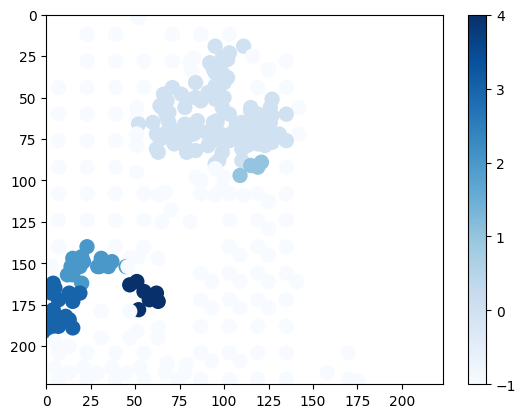

In [5]:
db = DBSCAN(eps=9, min_samples=5)
pred = db.fit_predict(p)
n_c = set(pred)
fig, ax = plt.subplots()
plt.scatter(x, y, s=100, c=pred, cmap="Blues")
plt.colorbar()
plt.xlim(0, 223)
plt.ylim(223, 0)
len(set(pred))

In [ ]:
type(pred)

In [ ]:
for i in range(1, 21):
    db = DBSCAN(eps=8, min_samples=i)
    pred = db.fit_predict(p)
    n_c = set(pred)
    fig, ax = plt.subplots()
    plt.scatter(x, y, s = 100, c = pred, cmap="Blues")
    plt.colorbar()
    plt.xlim(0, 223)
    plt.ylim(223, 0)
    print(len(set(pred)))

In [ ]:
#Shaply値を愚直に
from scipy.spatial import ConvexHull, Delaunay
from collections import defaultdict
class shaply_from_first_mid_output():
    
    def __init__(self, model : timm.models.mlp_mixer.MlpMixer) -> None:
        self.model = model
        self.class_names = None
        self.get_classes()
        self.inputs = []
        self.values = []
        self.block_output = None
        self.block_output_exchanged = None
        
        
    def get_classes(self):
        if not Path("data/imagenet_class_index.json").exists():
            # ファイルが存在しない場合はダウンロードする。
            download_url("https://git.io/JebAs", "data", "imagenet_class_index.json")

        # クラス一覧を読み込む。
        with open("data/imagenet_class_index.json") as f:
            data = json.load(f)
            self.class_names = [x["ja"] for x in data]

    def base_model_output(self, _input : torch.Tensor) -> tuple:
        """画像をモデルに入力した際の一番スコアが高いラベルとそのスコアを返す"""
        base_output = self.model(_input)
        batch_probs = F.softmax(base_output, dim=1)
        batch_probs, batch_indices = batch_probs.sort(dim=1, descending=True)

        return (self.class_names[batch_indices[0][0]], batch_probs[0][0].item())

    def in_hull_(self, point : list, hull : list):
        """点群hullからなる凸包内に点pointが入っているかを判定"""
        if not isinstance(hull, Delaunay):
            hull = Delaunay(hull)
        return hull.find_simplex(point) >= 0

"""
    def cal_paras_filitering(self):
        #にぶたんとかでフィルタリングのパラメータを求める
        return フィルタリングのパラメータ
    
    def cal_paras_DESCAN(self):
        #にぶたんとかでDBSCANのパラメータを求める
        return DBSCANのパラメータ
    
    def clustering(self):
        #DBSCAMを行って、クラスタのラベルを返す
        return pred
"""

    def calc_shaply(img : torch.Tensor):
        
        
        
        
        
        #クラスタごとに点群を求める。各点群の座標の最大値最小値も記録しておく
        clusters = defaultdict(lambda : [])
    
    

In [6]:
#Shaply値を愚直に
from scipy.spatial import ConvexHull, Delaunay
from collections import defaultdict
from math import factorial
def in_hull_(point : list, hull : list):
        """点群hullからなる凸包内に点pointが入っているかを判定"""
        if not isinstance(hull, Delaunay):
            hull = Delaunay(hull)
        return hull.find_simplex(point) >= 0
    
    
def get_classes():
    if not Path("data/imagenet_class_index.json").exists():
        # ファイルが存在しない場合はダウンロードする。
        download_url("https://git.io/JebAs", "data", "imagenet_class_index.json")

    # クラス一覧を読み込む。
    with open("data/imagenet_class_index.json") as f:
        data = json.load(f)
        class_names = [x["ja"] for x in data]
    return class_names

class_names = get_classes()

def base_model_output(_input : torch.Tensor) -> tuple:
    """画像をモデルに入力した際の一番スコアが高いラベルとそのスコアを返す"""
    base_output = model(_input)
    batch_probs = F.softmax(base_output, dim=1)
    batch_probs, batch_indices = batch_probs.sort(dim=1, descending=True)
    
    return (class_names[batch_indices[0][0]], batch_probs[0][0].item())

def calc_shaply(img : torch.Tensor, y : np.ndarray, x : np.ndarray, pred : np.ndarray):
    
    inputs = []
    values = []
    
    
    #クラスタ数
    n_c = len(set(pred)) - 1
    #shaply値格納
    shap = [0] * n_c
    #各マスクされた画像に対するスコア格納
    probs = [0] * pow(2, n_c)
    #マスクする際のバックアップ
    input_backup = defaultdict(lambda : [])
    
    
    #元々のスコアとクラス名とそのインデックスを取得。便宜上ここにおいておく
    base_class_name, base_prob = base_model_output(img)
    base_class_index = class_names.index(base_class_name)
    
    
    
    
    #クラスタごとに点群を求める。各点群の座標の最大値最小値も記録しておく
    clusters = defaultdict(lambda : [])
    left = defaultdict(lambda : 1000)
    right = defaultdict(lambda : -1000)
    up = defaultdict(lambda : 1000)
    down = defaultdict(lambda : -1000)
    
    for v, u, c in zip(y, x, pred):
        if c == -1:
            continue
        clusters[c].append((v, u))
        left[c] = min(left[c], u)
        right[c] = max(right[c], u)
        up[c] = min(up[c], v)
        down[c] = max(down[c], v)
        

    #全組み合わせを総当たり
    for i in range(2 ** n_c):
        flag = [True] * n_c #マスクされていたらFalse
        input_backup = defaultdict(lambda : [])
        for c in range(n_c):
            if i >> c & 1:
                flag[c] = False
                #マスクする
                for v in range(up[c], down[c] + 1):
                    for u in range(left[c], right[c] + 1):
                        if in_hull_([v, u], clusters[c]):
                            r, b, g = img[0, 0, v, u].item(), img[0, 1, v, u].item(), img[0, 2, v, u].item()
                            input_backup[(v, u)] = [r, b, g]
                            img[0, 0, v, u] = 0
                            img[0, 1, v, u] = 0
                            img[0, 2, v, u] = 0
        
        #モデルに流してスコアを得る
        tmp_output = model(img)
        tmp_batch_probs = F.softmax(tmp_output, dim=1)
        tmp_prob = tmp_batch_probs[0][base_class_index].item()
        
        probs[i] = tmp_prob
        
        """
        for c in range(n_c):
            if flag[c]:
                shap[c] += tmp_prob
        """
        
        inputs.append(copy.deepcopy(img))
        values.append(tmp_prob)
        
        #入力画像を元に戻す
        for key, val in input_backup.items():
            v, u = key
            r, b, g = val
            img[0, 0, v, u] = r
            img[0, 1, v, u] = b
            img[0, 2, v, u] = g
    
    for i in range(2 ** n_c):
        count = 0
        p = []
        for j in range(n_c):
            if i >> j & 1:
                count += 1
            else:
                p.append(j)
        for j in p:
            tmp = factorial(count) * factorial(n_c - count - 1) * (probs[i + pow(2, j)] - probs[i]) / factorial(n_c)
            shap[j] += tmp
            print(tmp,probs[i + pow(2, j)],probs[i])
    
    return shap, inputs, values
        
    
                            
                            
                
                
                


In [7]:
shap, _inputs, values = calc_shaply(inputs, y, x, pred)

-0.003872835636138916 0.8797565698623657 0.8991207480430603
-6.132125854492187e-05 0.8988141417503357 0.8991207480430603
-0.0013642072677612304 0.8922997117042542 0.8991207480430603
-0.002201569080352783 0.8881129026412964 0.8991207480430603
0.00010519027709960937 0.8996466994285583 0.8991207480430603
-4.210770130157471e-05 0.8789144158363342 0.8797565698623657
-9.454786777496338e-05 0.8778656125068665 0.8797565698623657
-0.00041179358959198 0.8715206980705261 0.8797565698623657
8.279681205749511e-05 0.8814125061035156 0.8797565698623657
-0.0009949862957000732 0.8789144158363342 0.8988141417503357
-0.00033349692821502683 0.8921442031860352 0.8988141417503357
-0.0005457311868667603 0.8878995180130005 0.8988141417503357
2.7611851692199707e-05 0.8993663787841797 0.8988141417503357
-6.931821505228679e-05 0.8768348693847656 0.8789144158363342
-0.0002864956855773926 0.8703195452690125 0.8789144158363342
5.593697230021159e-05 0.8805925250053406 0.8789144158363342
-0.0007217049598693848 0.8778

In [8]:
shap

[-0.018668954571088157,
 -0.0003882348537445069,
 -0.015449518958727518,
 -0.020771607756614685,
 0.0022184401750564575]

In [77]:
cover_img = np.zeros((224, 224, 4), dtype=np.uint8)
for i in range(224):
    for j in range(224):
        cover_img[i, j, 3] = 0
for i, j, c in zip(y, x, pred):
    if c == 0 or c == 1: #shapの値がなぜか変わってしまっているのでひとまずスライド用にクラスタ番号を指定してる。ほんとはshapの値によって場合分け
        cover_img[i, j, 0] = 255
        cover_img[i, j, 3] = 255
cover_img = Image.fromarray(cover_img)

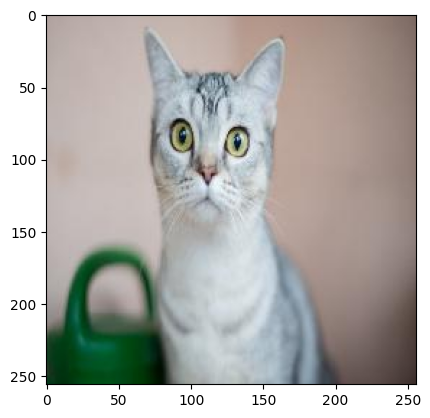

In [82]:
plt.imshow(img)

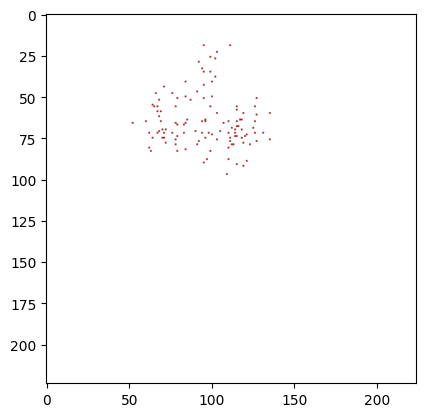

In [78]:
plt.imshow(cover_img)

In [89]:
base_img = transform_beta(img)

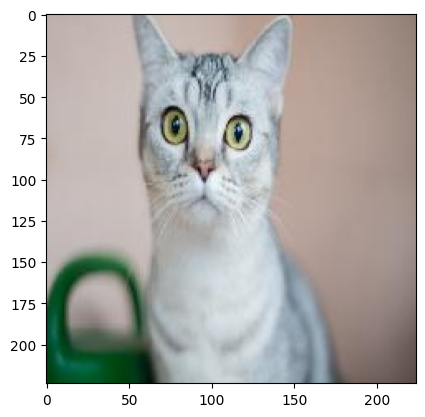

In [90]:
plt.imshow(base_img)

In [91]:
base_img.paste(cover_img, (0, 0), cover_img)

PIL.Image.Image

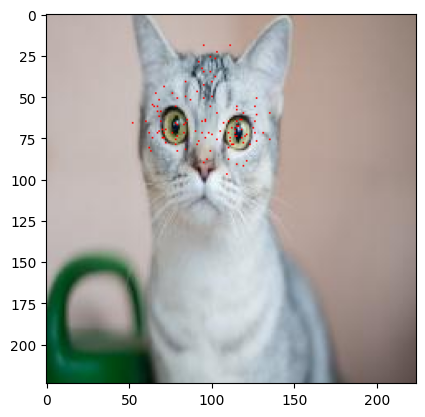

In [92]:
plt.imshow(base_img)

In [ ]:
if 1 & 0:
    print("Yes")

(223.0, 0.0)

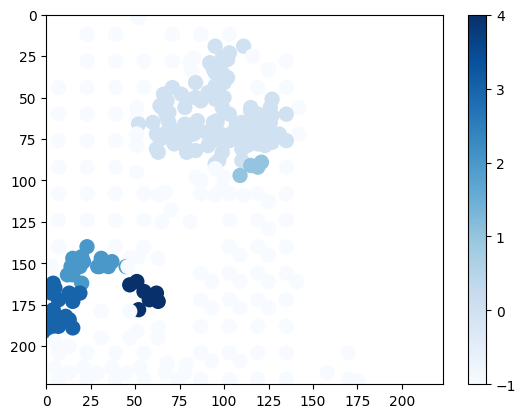

In [10]:
fig, ax = plt.subplots()
plt.scatter(x, y, s=100, c=pred, cmap="Blues")
plt.colorbar()
plt.xlim(0, 223)
plt.ylim(223, 0)

In [ ]:
inputs.shape

In [ ]:
output = model(tmp)

In [ ]:
mid = model.blocks[0].block_output
mid = exchange.exchange_tensor_to_array(mid)

In [ ]:
exchange.show_heatmap_with_colorbar(mid)

In [ ]:
len(np.where(mid<-0.5)[0])

In [ ]:
tmp2 = torch.ones(1,3,224,224)
tmp2 *= 255
output2 = model(tmp2)
mid2 = model.blocks[0].block_output
mid2 = exchange.exchange_tensor_to_array(mid2)
exchange.show_heatmap_with_colorbar(mid2)

In [ ]:
len(np.where(abs(mid2) < 10)[0])

In [ ]:
mid2b = np.where(abs(mid2) < 25, 255, 0)
plt.imshow(mid2b)

In [ ]:
mid3 = mid + mid2 / 400

In [ ]:
exchange.show_heatmap_with_colorbar(mid3)